In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 定义 SE 模块
class SEModule(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# 定义 ResNet 基本块（带 SE 结构）
class SEBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, reduction=16):
        super(SEBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.se = SEModule(planes, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# 定义 ResNet（带 SE 结构）
class SEResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(SEResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def SEResNet18():
    return SEResNet(SEBasicBlock, [2, 2, 2, 2])

In [2]:
net =SEResNet18()
print(net)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = net.to(device)

SEResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): SEBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (se): SEModule(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (fc): Sequential(
          (0): Linear(in_features=64, out_features=4, bias=False)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=4, out_features=64, bias=False)
          (3): Sigmoid()
        )
      )
      (shortcut): Sequ

In [3]:
# 训练和评估函数

def train_and_evaluate(model, trainloader, testloader, num_epochs=10, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%, Test Accuracy: {test_acc:.2f}%')
        scheduler.step()
     # 绘制损失和准确度曲线
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # 绘制训练损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 绘制训练和测试准确度曲线
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test accuracy')
    plt.title('Training and Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 1.4216, Train Accuracy: 47.73%, Test Accuracy: 59.04%
Epoch [2/10], Loss: 0.9209, Train Accuracy: 67.34%, Test Accuracy: 70.67%
Epoch [3/10], Loss: 0.7203, Train Accuracy: 74.57%, Test Accuracy: 73.85%
Epoch [4/10], Loss: 0.6111, Train Accuracy: 78.58%, Test Accuracy: 77.31%
Epoch [5/10], Loss: 0.5324, Train Accuracy: 81.59%, Test Accuracy: 79.78%
Epoch [6/10], Loss: 0.4778, Train Accuracy: 83.31%, Test Accuracy: 80.47%
Epoch [7/10], Loss: 0.4392, Train Accuracy: 84.70%, Test Accuracy: 81.59%
Epoch [8/10], Loss: 0.3960, Train Accuracy: 86.28%, Test Accuracy: 84.66%
Epoch [9/10], Loss: 0.3673, Train Accuracy: 87.23%, Test Accuracy: 84.58%
Epoch [10/10], Loss: 0.3438, Train Accuracy: 88.06%, Test Accuracy: 83.80%


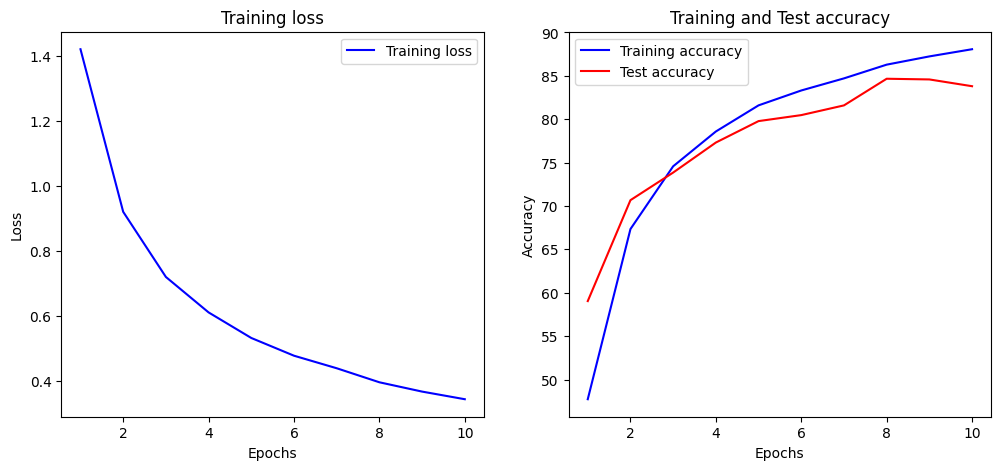

In [4]:

    
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

train_and_evaluate(model, trainloader, testloader, num_epochs=10, learning_rate=0.01)